# Premise

## Who we are: Aqua Partners - Public Sector Consulting Firm specialized in economic development

## Stakeholder: Tanzanian Government

## Objective: Assist the government in improving the funcitonality of future waterpumps installed in the country using the existing range of infrastructure 

## Dataset: Status and features of waterpumps installed in Tanzania to provide water supply to cities / villages



# Definitions 

amount_tsh - Total static head (amount water available to waterpoint) / date_recorded - The date the row was entered

funder - Who funded the well / gps_height - Altitude of the well

installer - Organization that installed the well / longitude - GPS coordinate 

latitude - GPS coordinate / wpt_name - Name of the waterpoint if there is one

basin - Geographic water basin / subvillage - Geographic location / region - Geographic location

region_code - Geographic location (coded)/ district_code - Geographic location (coded)

lga - Geographic location / ward - Geographic location /population - Population around the well

public_meeting - True/False / recorded_by - Group entering this row of data / scheme_management - Who operates the waterpoint

scheme_name - Who operates the waterpoint / permit - If the waterpoint is permitted

construction_year - Year the waterpoint was constructed / extraction_type - The kind of extraction the waterpoint uses

extraction_type_group - The kind of extraction the waterpoint uses / extraction_type_class - The kind of extraction the waterpoint uses

management - How the waterpoint is managed / management_group - How the waterpoint is managed

payment - What the water costs / payment_type - What the water costs

water_quality - The quality of the water / quality_group - The quality of the water

quantity - The quantity of water / quantity_group - The quantity of water

source - The source of the water / source_type - The source of the water

source_class - The source of the water / waterpoint_type - The kind of waterpoint

waterpoint_type_group - The kind of waterpoint

# Package Installation

In [1]:
import pandas as pd
import numpy as np
import geopandas as geo
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from IPython.display import Image  
from pydotplus import graph_from_dot_data
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from ml_repo import scores
from ml_repo import roc_plot
from ml_repo import annot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


# Dataset

The labels in this dataset are simple. There are three possible values:
functional - the waterpoint is operational and there are no repairs needed
functional needs repair - the waterpoint is operational, but needs repairs
non functional - the waterpoint is not operational

In [2]:
X = pd.read_csv('Data/X.csv')
y = pd.read_csv('Data/Y.csv')
X1 = pd.read_csv('Data/X1.csv')

df = pd.merge(y,X,on='id')

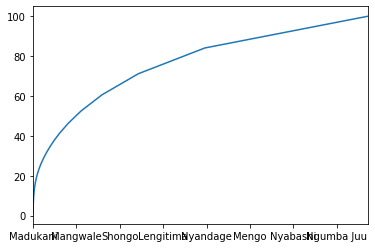

In [3]:
(df.subvillage.value_counts(normalize = True)*100).cumsum().plot()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
status_group             59400 non-null object
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
p

In [5]:
df['installer'].fillna('other', inplace = True)
df['funder'].fillna('other', inplace = True)
df['public_meeting'].fillna('False', inplace = True)
df['scheme_management'].fillna('other',inplace = True)
df['permit'].fillna('False', inplace = True)
df.drop(columns =['recorded_by', 'extraction_type_group','extraction_type_class', 'payment', 'quantity_group', 'source', 'source_class', 'id', 'num_private', 'quantity_group','waterpoint_type_group', 'wpt_name', 'scheme_name', 'amount_tsh'], inplace = True)
df['region_and_code'] = df['region'] + df['region_code'].map(str)
df.drop(columns = ['region', 'region_code'], inplace = True)
df.population.replace(0,df.groupby(['district_code']).population.mean(), inplace = True)


In [6]:
i = df.construction_year.median()
df.construction_year.replace(0,i,inplace=True)

j = df.groupby(['basin']).gps_height.mean()
df.gps_height.replace(0,j, inplace = True)



In [7]:
df['year'] = df.date_recorded.str[:4]
df['month'] = df.date_recorded.str[-4]
df.drop(columns = ['date_recorded'], inplace = True)
df['length_operation'] = df.year.map(int) - df.construction_year.map(int)

In [8]:
cols = [i for i in df.columns if type(df[i].iloc[0]) == str]
df[cols] = df[cols].where(df[cols].apply(lambda x: x.map(x.value_counts())) > 50,"other")

In [9]:
df.nunique()

status_group             3
funder                 143
gps_height            2428
installer              144
longitude            57516
latitude             57517
basin                    9
subvillage              61
district_code           20
lga                    124
ward                   309
population            1056
public_meeting           3
scheme_management       12
permit                   3
construction_year       54
extraction_type         15
management              12
management_group         5
payment_type             7
water_quality            8
quality_group            6
quantity                 5
source_type              7
waterpoint_type          6
region_and_code         28
year                     4
month                   10
length_operation        60
dtype: int64

# Data Transformation

In [10]:
scaler = MinMaxScaler()
conti = df.loc[:,['population', 'gps_height', 'length_operation']]
df[['population', 'gps_height', 'length_operation']] = scaler.fit_transform(df[['population', 'gps_height', 'length_operation']])
df

,status_group,funder,gps_height,installer,longitude,latitude,basin,subvillage,district_code,lga,...,payment_type,water_quality,quality_group,quantity,source_type,waterpoint_type,region_and_code,year,month,length_operation
0,functional,Roman,0.517483,Roman,34.938093,-9.856322,Lake Nyasa,other,5,Ludewa,...,annually,soft,good,enough,spring,communal standpipe,Iringa11,2011,3,0.316667
1,functional,Grumeti,0.520629,other,34.698766,-2.147466,Lake Victoria,other,2,Serengeti,...,never pay,soft,good,insufficient,rainwater harvesting,communal standpipe,Mara20,2013,3,0.166667
2,functional,other,0.271329,World vision,37.460664,-3.821329,Pangani,Majengo,4,Simanjiro,...,per bucket,soft,good,enough,dam,communal standpipe multiple,Manyara21,2013,2,0.183333
3,non functional,Unicef,0.123427,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,other,63,Nanyumbu,...,never pay,soft,good,dry,borehole,communal standpipe multiple,Mtwara90,2013,1,0.566667
4,functional,other,0.031469,Artisan,31.130847,-1.825359,Lake Victoria,other,1,Karagwe,...,never pay,soft,good,seasonal,rainwater harvesting,communal standpipe,Kagera18,2011,7,0.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,functional,Germany Republi,0.454545,CES,37.169807,-3.253847,Pangani,other,5,Hai,...,per bucket,soft,good,enough,spring,communal standpipe,Kilimanjaro3,2013,5,0.350000
59396,functional,other,0.455245,other,35.249991,-9.070629,Rufiji,other,4,Njombe,...,annually,soft,good,enough,river/lake,communal standpipe,Iringa11,2011,5,0.366667
59397,functional,other,0.031469,other,34.017087,-8.750434,Rufiji,other,7,Mbarali,...,monthly,fluoride,fluoride,enough,borehole,hand pump,Mbeya12,2011,4,0.533333
59398,functional,other,0.031469,other,35.861315,-6.378573,Rufiji,other,4,Chamwino,...,never pay,soft,good,insufficient,shallow well,hand pump,Dodoma1,2011,3,0.533333


In [11]:
df.columns

Index(['status_group', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'subvillage', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source_type', 'waterpoint_type', 'region_and_code', 'year',
       'month', 'length_operation'],
      dtype='object')

In [12]:
y = df['status_group']

X = df.loc[:, ['funder', 'gps_height', 'installer',
       'basin', 'subvillage', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source_type', 'waterpoint_type', 'region_and_code', 'year',
       'month', 'length_operation']]

X1 = pd.get_dummies(X, prefix = ['funder', 'installer',
       'basin', 'subvillage', 'district_code', 'lga', 'ward',
       'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'management',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source_type', 'waterpoint_type', 'region_and_code'])

y1 = pd.get_dummies(y, prefix = ['status_group'])
y1 = y1.iloc[:,0]
X1.shape

(59400, 926)

# Initial split of DataSet (Train / Test set)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42, test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42) 
skf = StratifiedKFold(n_splits=5,random_state=42)

# Model - Decision Tree

train: 1.0 test: 0.8


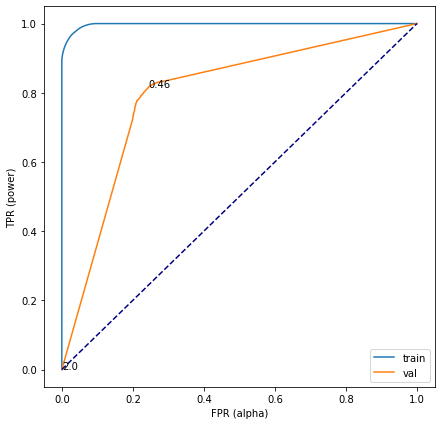

CPU times: user 5.46 s, sys: 607 ms, total: 6.07 s
Wall time: 6.33 s


In [14]:
%%time

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

In [15]:
%%time
clf = DecisionTreeClassifier()
param_grid = {'criterion':['gini','entropy'], 'max_depth': [2,3,4], 'min_samples_leaf':[1500, 2000, 2500]}
gs = GridSearchCV(clf, param_grid, cv = skf)

gs.fit(X_train, y_train)
gs.best_params_

CPU times: user 1min 1s, sys: 15.8 s, total: 1min 17s
Wall time: 1min 10s


{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1500}

In [16]:
y_preds = gs.predict(X_train)
print('Accuracy: ', accuracy_score(y_train, y_preds))

Accuracy:  0.7145675505050505


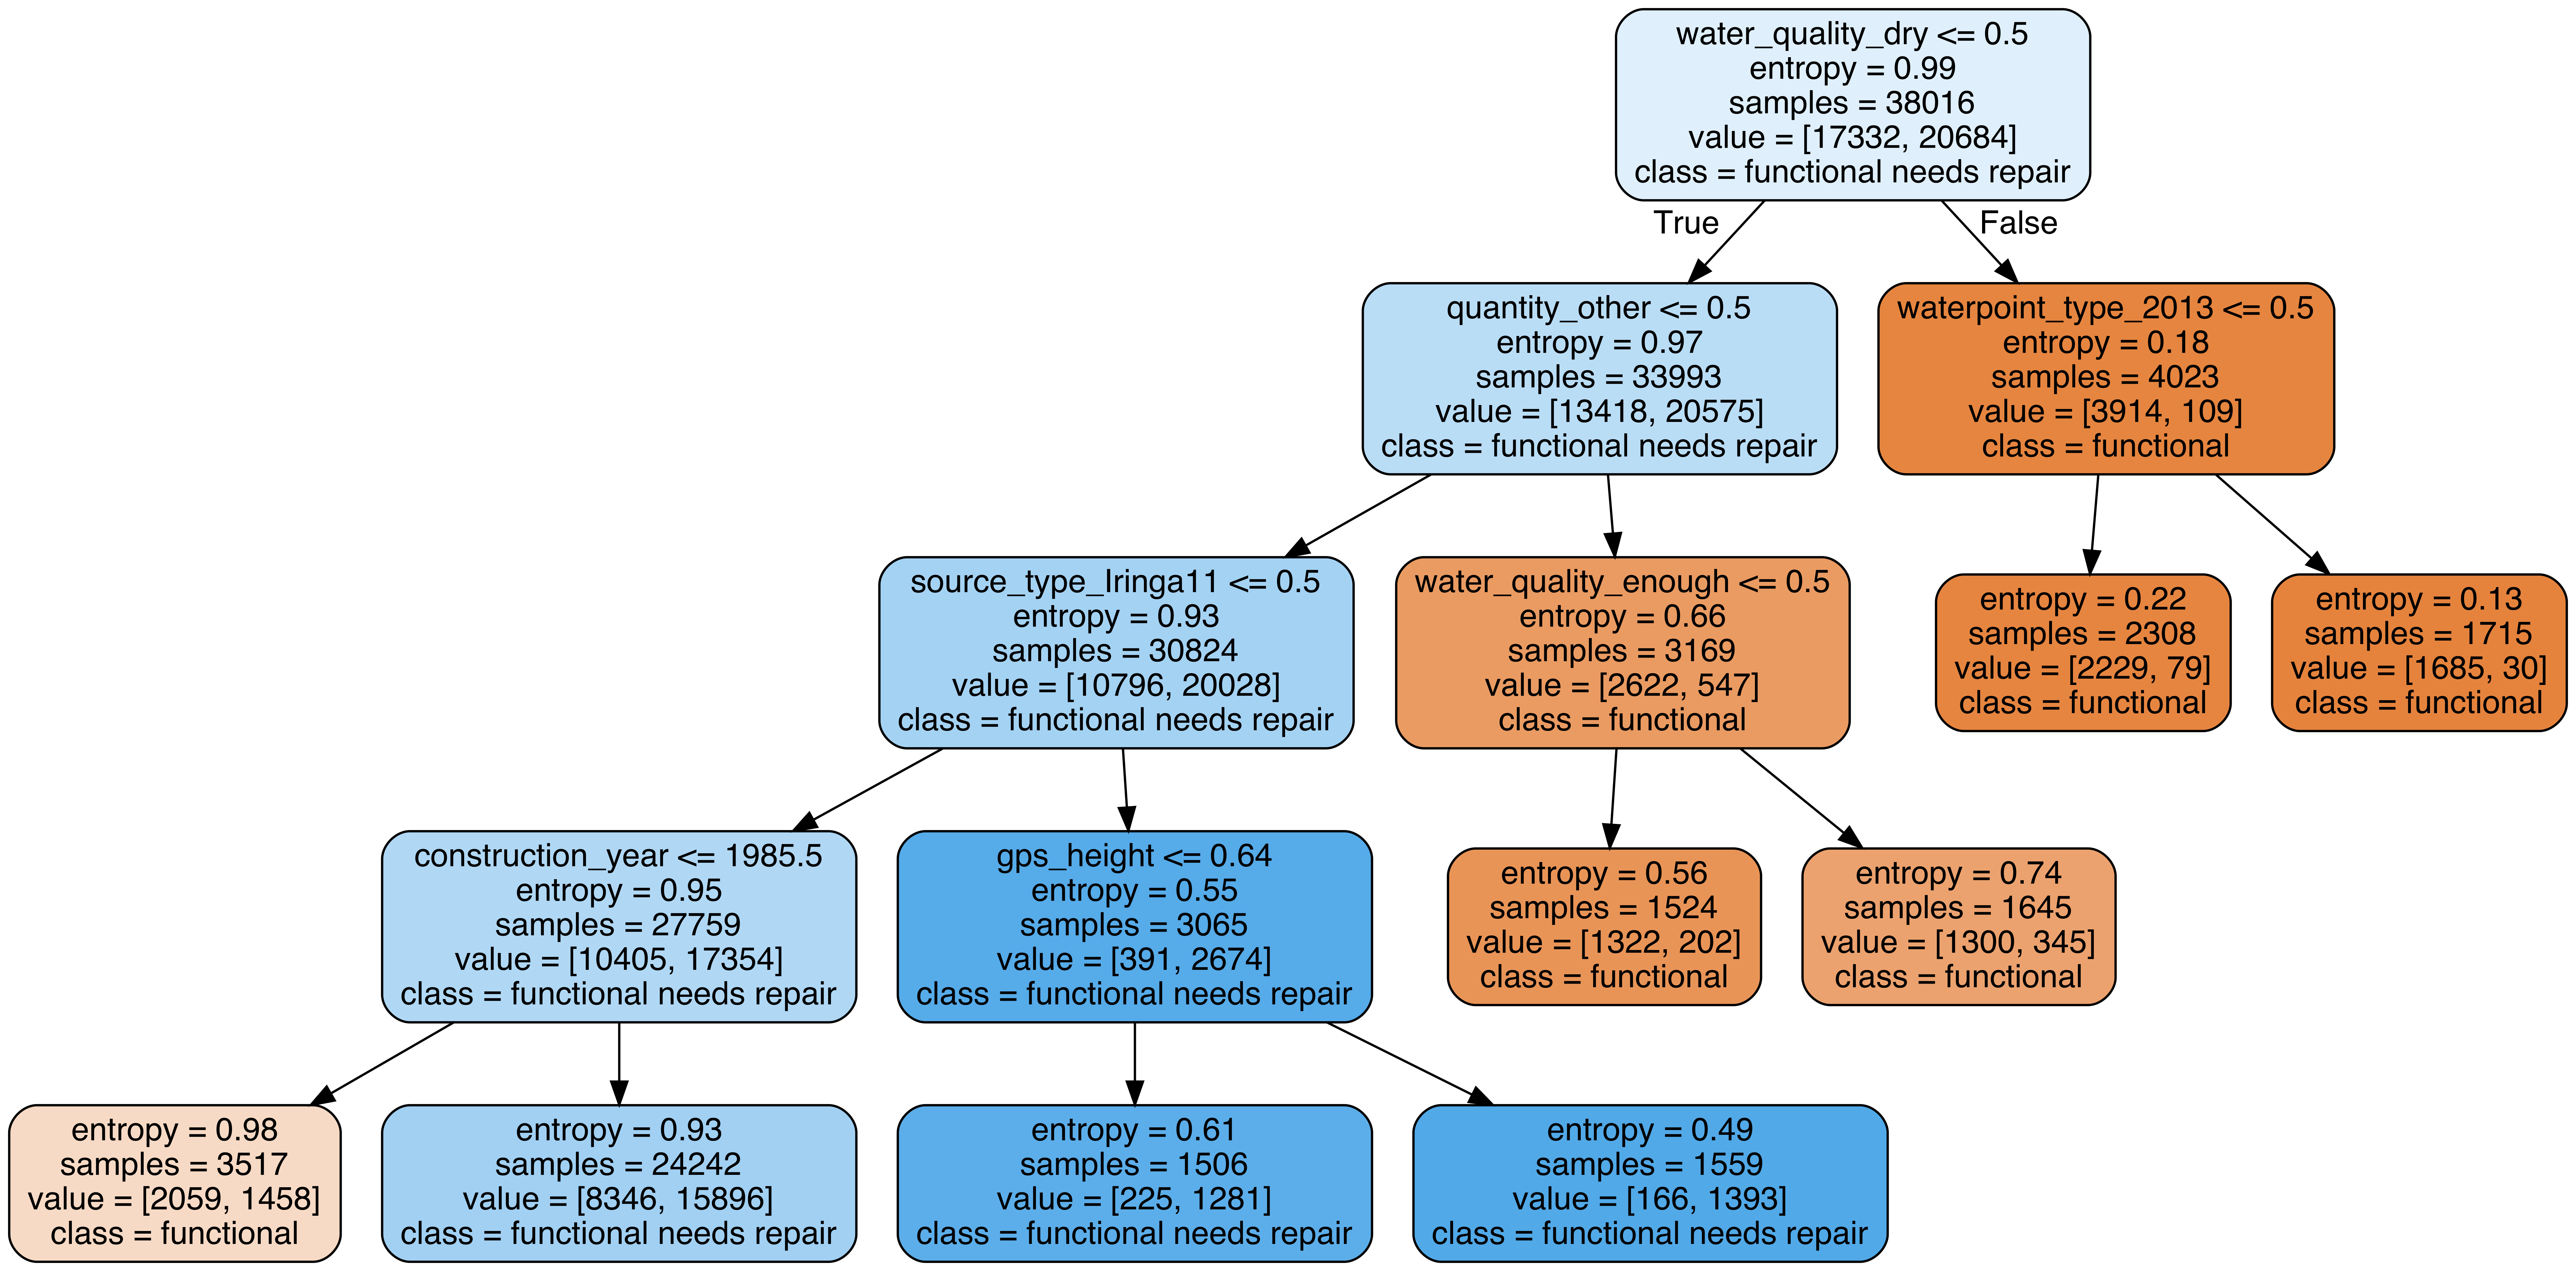

In [17]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 4, min_samples_leaf = 1500)
clf.fit(X_train, y_train) #encoded categorical variable using pd.get_dummies()

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(clf, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = np.unique(y).astype(str),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png 
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Model - Logistic Regression 

In [18]:
%%time

logreg = LogisticRegression(fit_intercept = False, C = 1e15, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

CPU times: user 1.69 s, sys: 289 ms, total: 1.98 s
Wall time: 2.11 s


LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
model_log.coef_

array([[-6.85721929e-02,  8.73321874e-03,  1.33120026e+00,
         4.66804036e-04, -1.50498943e+00,  1.38739230e-01,
        -1.12463949e-01, -6.45967326e-01,  1.38285204e+00,
         5.30081922e-01, -3.48853306e-01,  4.41805108e-01,
        -7.89020327e-01, -3.23185370e-01,  1.08467186e-01,
         2.02408465e-01, -4.42531059e-01,  2.64507123e-01,
         7.97967985e-01, -1.46637102e-01,  1.44393829e-01,
        -5.65445181e-01, -2.77271345e-01,  1.03287160e-01,
        -3.97282282e-01,  6.33358768e-01,  9.42751006e-01,
        -3.26492624e-01, -3.81072301e-01,  1.41410811e-01,
         3.57522335e-01, -4.05441117e-02, -2.16570308e-01,
         3.73435760e-01, -3.71384186e-01, -5.11817720e-01,
        -2.18990047e-01, -5.59092823e-01,  4.46909240e-01,
         2.14140010e-01,  5.72077740e-01, -1.75679902e-01,
        -1.81061878e-01, -4.24547680e-02,  5.74815712e-02,
        -4.72103513e-01,  8.57971602e-01, -3.32868405e-01,
        -8.01617391e-02, -3.71957299e-02, -2.29108812e-0

In [20]:
train_prob = model_log.predict_proba(X_train)[:,1]
val_prob = model_log.predict_proba(X_val)[:,1]

In [21]:
from sklearn.metrics import roc_auc_score
train = roc_auc_score(y_train,train_prob)
val = roc_auc_score(y_val,val_prob)
print('train: ', round(train,2),'//',"validation: ", round(val,2))

train:  0.87 // validation:  0.86


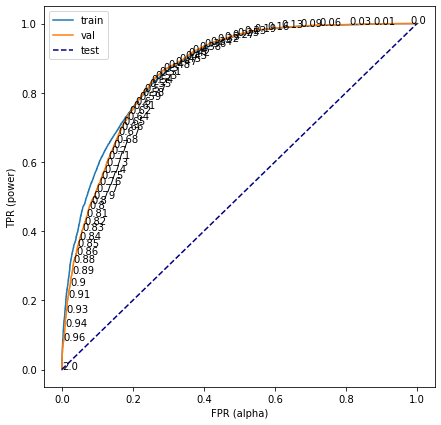

In [22]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(7,7))

for data in [[y_train, train_prob],[y_val, val_prob]]:
    fpr, tpr, threshold = roc_curve(data[0], data[1])
    plt.plot(fpr, tpr)
annot(fpr, tpr, threshold)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.ylabel('TPR (power)')
plt.xlabel('FPR (alpha)')
plt.legend(['train','val','test'])
plt.show()

# Model - Random Forest

In [23]:
from ml_repo import roc_plot


# Model - K-Nearest-Neighbors

# Model - Support Vector Machines